In [199]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn

## DATA FROM KAGGLE

In [200]:
train_data = pd.read_csv("train.csv", delimiter=",")

### Training data size

In [201]:
print(len(train_data),  "instances")

2400 instances


### Columns in train data

In [202]:
cols = pd.DataFrame(train_data.dtypes)
cols

,0
id,int64
spacegroup,int64
number_of_total_atoms,float64
percent_atom_al,float64
percent_atom_ga,float64
percent_atom_in,float64
lattice_vector_1_ang,float64
lattice_vector_2_ang,float64
lattice_vector_3_ang,float64
lattice_angle_alpha_degree,float64


### Checking if any of the columns have missing values

In [203]:
train_data.isnull().values.any(axis=0)

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False])

### Histogram of values

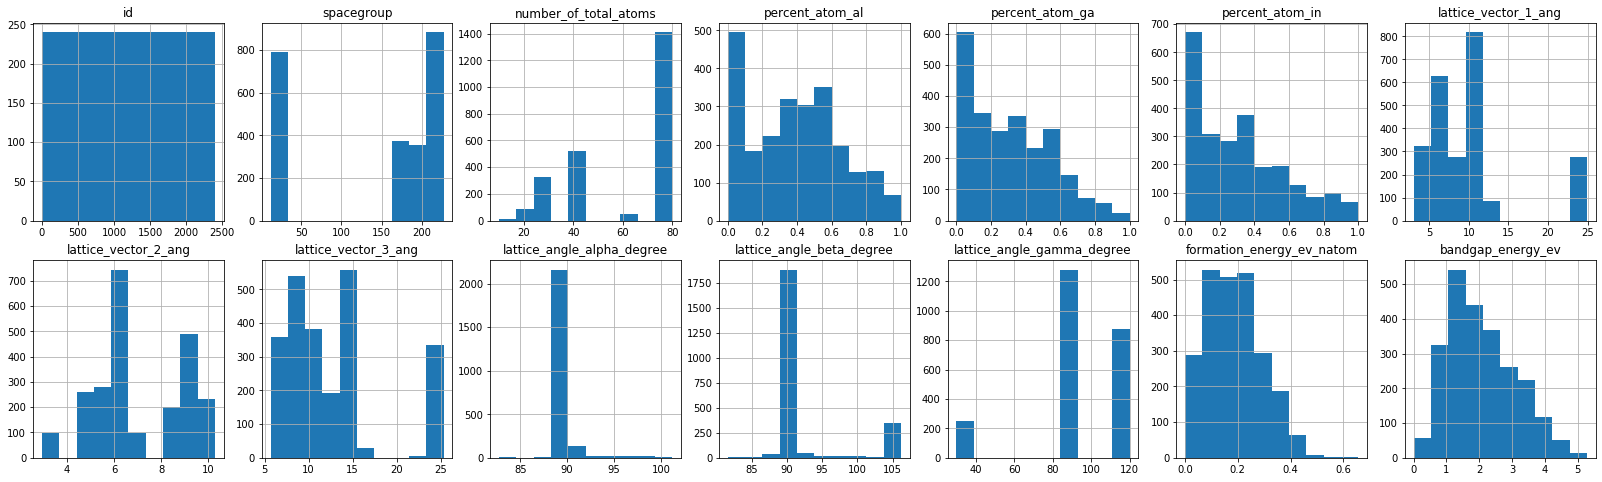

In [204]:
fig, ax = plt.subplots(nrows=2, ncols=7, figsize=(28,8))
for col, ax_i in zip(train_data.columns, ax.flatten()):
    train_data[col].hist(ax=ax_i)
    ax_i.set_title(col)
plt.show()

**We can drop id because it contains no useful information for us**

In [205]:
train_data = train_data.drop("id", axis=1)

### Correlations between values

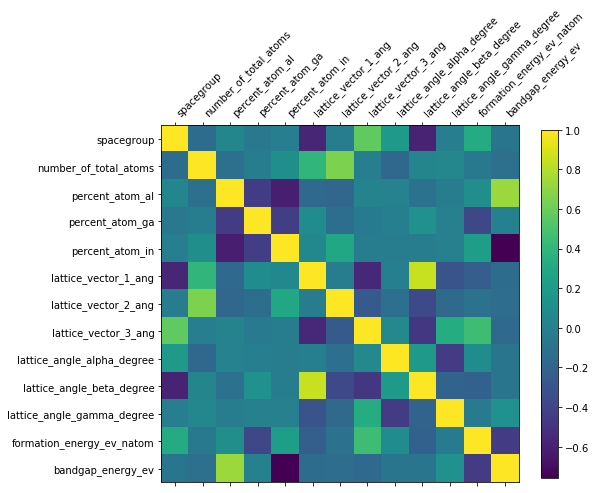

In [206]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
cax = ax.matshow(train_data.corr())
ax.set_xticklabels(train_data.columns, rotation = 45, ha="left")
ax.set_yticklabels(train_data.columns)
ax.set_xticks(np.arange(0,13,1))
ax.set_yticks(np.arange(0,13,1))
ax.set_ylim(bottom=12.5, top=-0.5)
fig.colorbar(cax, shrink=0.8)

plt.show()

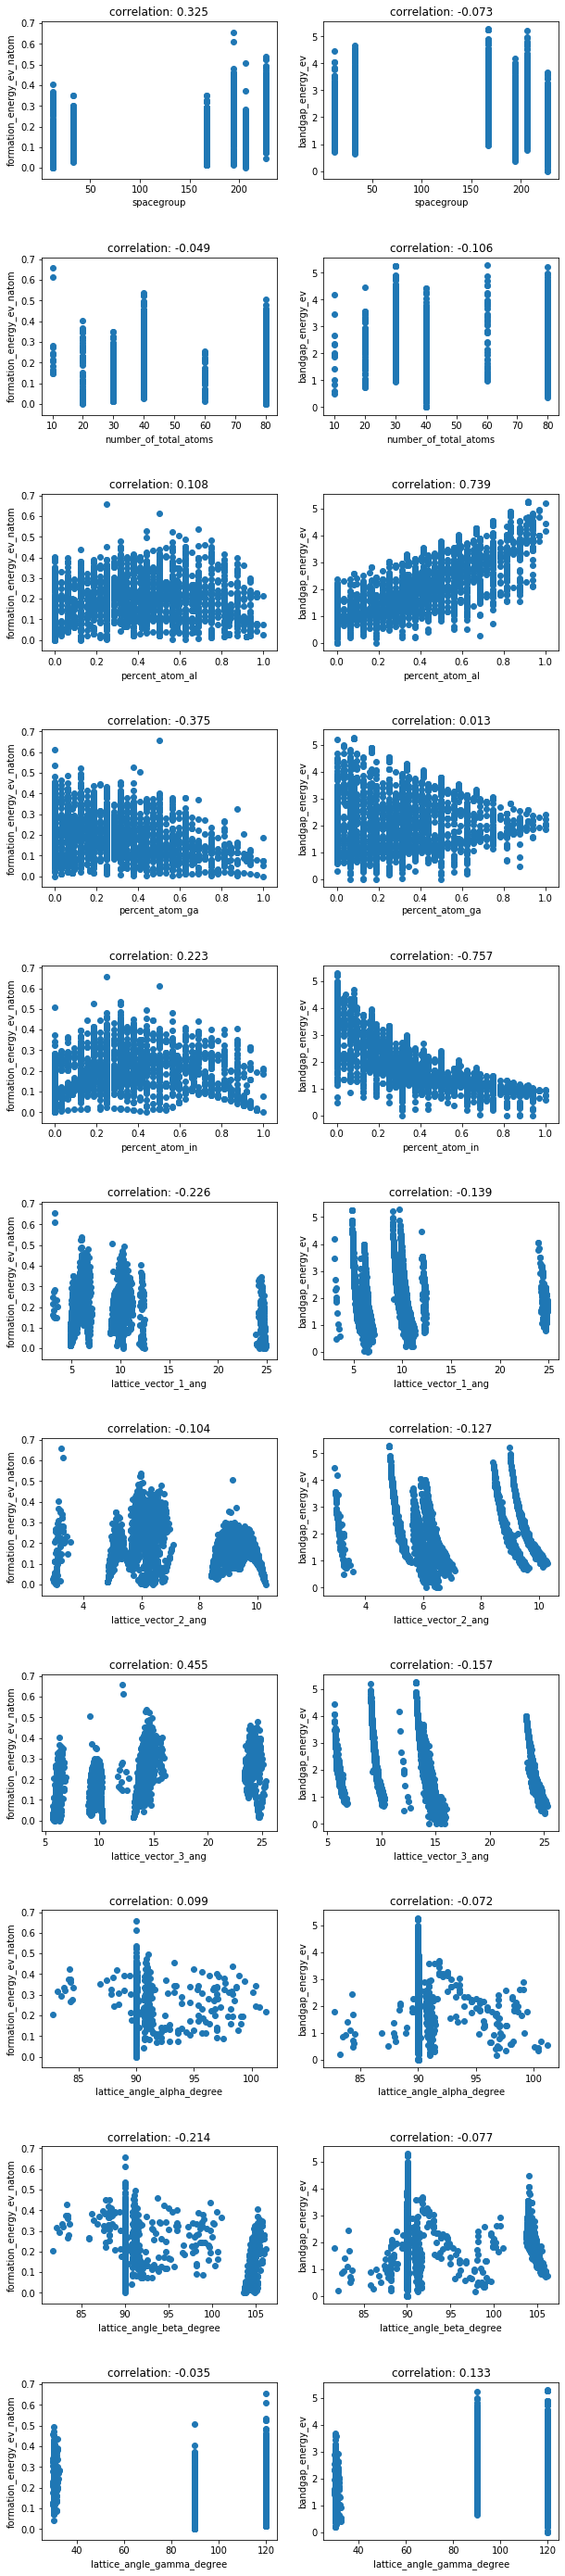

In [207]:
fig, ax = plt.subplots(nrows=11, ncols=2, figsize=(10,50))
plt.subplots_adjust(hspace=0.5)
for col, ax_i in zip(train_data.columns[:-2], ax):
    ax_i[0].scatter(train_data[col], train_data["formation_energy_ev_natom"])
    ax_i[1].scatter(train_data[col], train_data["bandgap_energy_ev"])
    ax_i[0].set_xlabel(col)
    ax_i[0].set_ylabel("formation_energy_ev_natom")
    ax_i[1].set_xlabel(col)
    ax_i[1].set_ylabel("bandgap_energy_ev")
    ax_i[0].set_title("correlation: " +   str(round(train_data[col].corr(train_data['formation_energy_ev_natom']), 3)))
    ax_i[1].set_title("correlation: " +  str(round(train_data[col].corr(train_data['bandgap_energy_ev']), 3)))

In [208]:
from sklearn.model_selection import train_test_split
X = train_data.drop(["formation_energy_ev_natom", "bandgap_energy_ev"], axis=1)
y_fe = train_data.formation_energy_ev_natom
y_be = train_data.bandgap_energy_ev
X_tr, X_te, y_fe_tr, y_fe_te, y_be_tr, y_be_te = train_test_split(X, y_fe, y_be, test_size=0.1)

In [209]:
from sklearn.metrics import mean_squared_log_error
def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

In [210]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(n_estimators=100).fit(X_tr, y_fe_tr)
#  root mean squared logarithmic error is used for evaluation
print("train error:", rmsle(y_fe_tr, rfr.predict(X_tr)))
print("test error:", rmsle(y_fe_te, rfr.predict(X_te)) )

train error: 0.020575759595592682
test error: 0.036020168344913145


In [211]:
print("feature importances")
pd.DataFrame([X.columns, rfr.feature_importances_])


feature importances


,0,1,2,3,4,5,6,7,8,9,10
0,spacegroup,number_of_total_atoms,percent_atom_al,percent_atom_ga,percent_atom_in,lattice_vector_1_ang,lattice_vector_2_ang,lattice_vector_3_ang,lattice_angle_alpha_degree,lattice_angle_beta_degree,lattice_angle_gamma_degree
1,0.0284339,0.00313113,0.137074,0.0640736,0.198992,0.0417711,0.0813983,0.379928,0.0224015,0.0286688,0.0141285


## CONSTRUCTED FEATURES

In [212]:
additional_train_data = pd.read_csv("additionalAttributes.csv", delimiter=",")

### Columns

In [213]:
cols = pd.DataFrame(additional_train_data.dtypes)
cols

,0
Unnamed: 0,int64
Nr,float64
cAlGa,float64
cAlIn,float64
cAlO,float64
cGaAl,float64
cGaIn,float64
cGaO,float64
cInAl,float64
cInGa,float64


In [214]:
print(len(cols), "columns")

24 columns


In [216]:
additional_train_data = additional_train_data.drop("Unnamed: 0", axis=1)

In [215]:
for i, t in enumerate(additional_train_data.isnull().values.any(axis=0)):
    if t:
        print(additional_train_data.columns[i])

cInAl
cInGa
cInO
distGaO
distInAl
distInGa
qAl
qGa
qIn


These columns have missing values

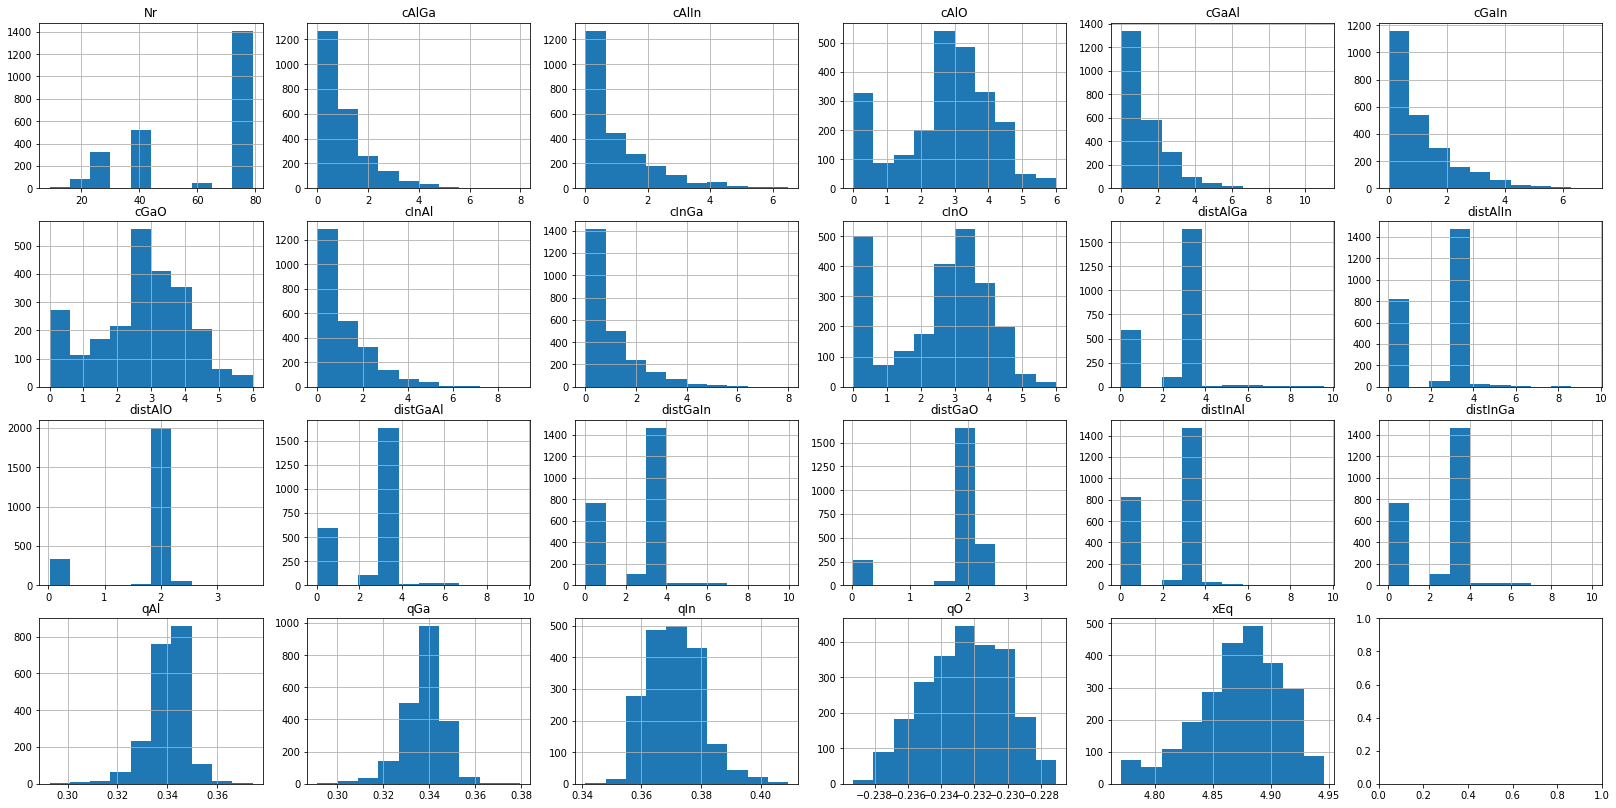

In [217]:
fig, ax = plt.subplots(nrows=4, ncols=6, figsize=(28,14))
for col, ax_i in zip(additional_train_data.columns, ax.flatten()):
    additional_train_data[col].hist(ax=ax_i)
    ax_i.set_title(col)
plt.show()

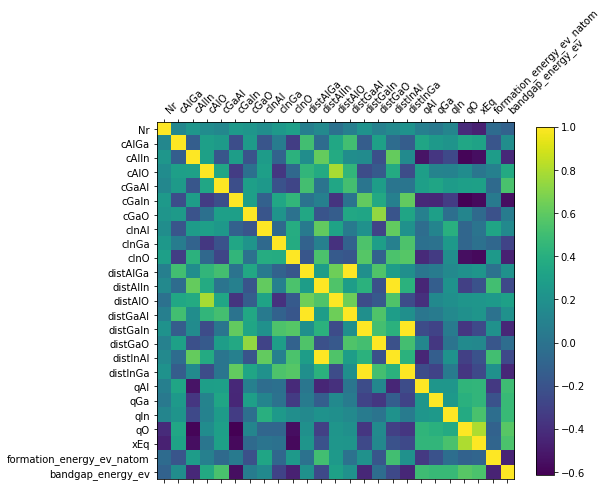

In [221]:
additional_data = pd.concat([additional_train_data, train_data[["formation_energy_ev_natom", "bandgap_energy_ev"]]], axis=1)
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
cax = ax.matshow(additional_data.corr())
ax.set_xticklabels(additional_data.columns, rotation = 45, ha="left")
ax.set_yticklabels(additional_data.columns)
ax.set_xticks(np.arange(0,25,1))
ax.set_yticks(np.arange(0,25,1))
ax.set_ylim(bottom=24.5, top=-0.5)
fig.colorbar(cax, shrink=0.8)

plt.show()